In [ ]:
import torch
import matplotlib.pyplot as plt
from math import log2
from utils import *

In [ ]:
x = torch.rand(50,50,3)

<matplotlib.image.AxesImage>

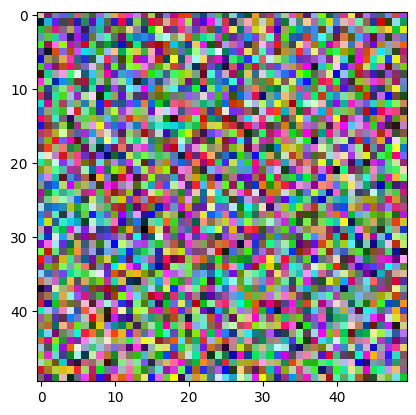

In [ ]:
plt.imshow(x)

We can discretize image by putting similar float values into the same buckets.

In [ ]:
# number of buckets
def quantize(x, n_bins, as_pixels=False):
    buckets = torch.linspace(0, 1, n_bins+1)
    res = torch.bucketize(x, buckets)-1
    if not as_pixels: return res
    return (buckets[res]*256).type(torch.uint8)

In [ ]:
k = 2
x_m = quantize(x, k, True)

Text(0.5, 1.0, '3.0 bit image')

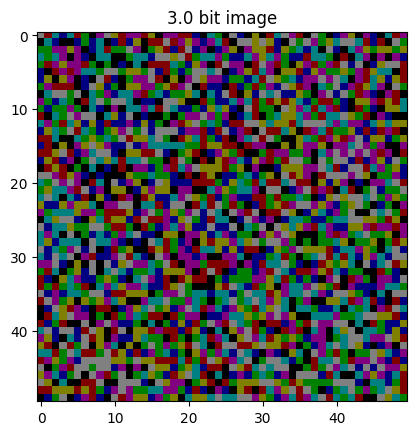

In [ ]:
plt.imshow(x_m)
plt.title(f"{3*log2(k)} bit image")

Now we'll look closer at a single channel of the image.

In [ ]:
x = x[:,:,0].clone()

<matplotlib.image.AxesImage>

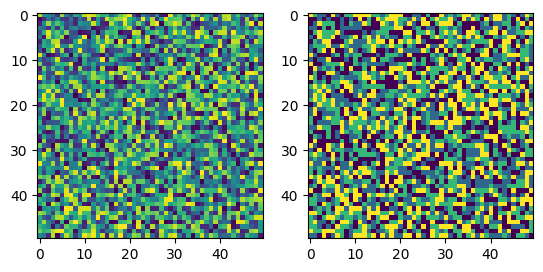

In [ ]:
axes = plt.subplots(ncols=2)[1]
axes[0].imshow(x)
axes[1].imshow(quantize(x,4))

In [ ]:
def step(x, rad=4):
    w,h = x.shape
    out = torch.zeros_like(x)
    for i in range(w):
        for j in range(h):
            block = x[max(i-rad,0):min(i+rad,w), max(j-rad,0):min(j+rad,h)]
            color = torch.argmax(torch.bincount(block.flatten()))
            out[i,j]=color
    return out

def steps(x, n=1):
    for _ in range(n):
        x = step(x)
    return x

In [ ]:
y = quantize(x, 5)

<matplotlib.image.AxesImage>

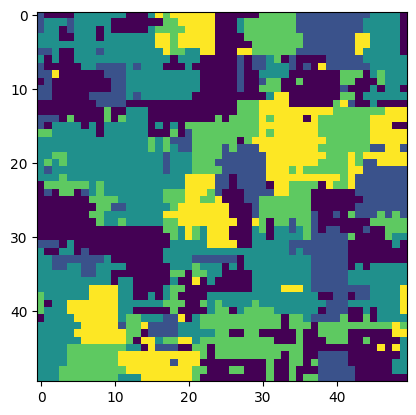

In [ ]:
plt.imshow(step(y))

In [ ]:
mod = load_cu_file('./mode_filter.cu', False)

In [ ]:
y = y.type(torch.int32)

In [ ]:
mod.mode_filter2d(y.cuda(), 3)

tensor([[1, 1, 1,  ..., 2, 2, 2],
        [0, 2, 2,  ..., 2, 2, 2],
        [0, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 0, 0],
        [0, 0, 0,  ..., 2, 0, 0],
        [0, 2, 2,  ..., 2, 2, 2]], device='cuda:0', dtype=torch.int32)

<matplotlib.image.AxesImage>

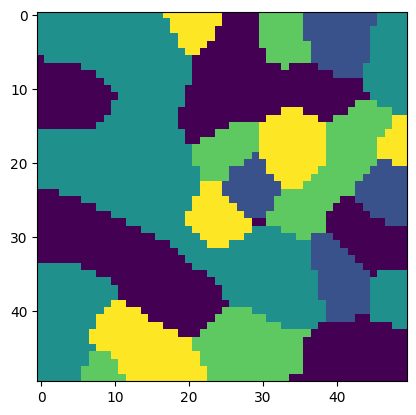

In [ ]:
plt.imshow(step(step(step(y))))

In [ ]:
x = torch.rand(500,500)
y = quantize(x, 3).type(torch.int32)

<matplotlib.image.AxesImage>

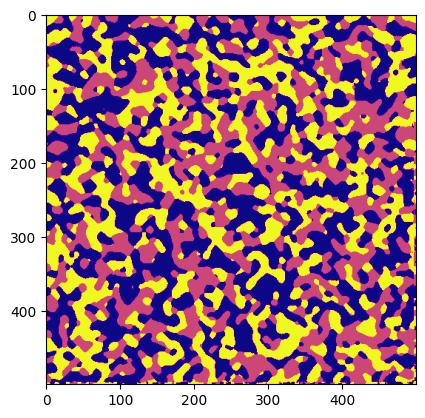

In [ ]:
plt.imshow(f(f((f(y)))).cpu(), cmap='plasma')

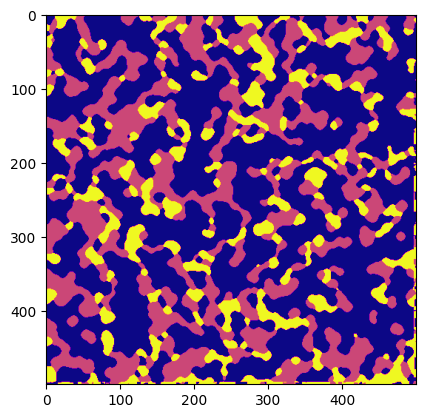

In [ ]:
from matplotlib.animation import ArtistAnimation

n = 500
k = 2
x = quantize(torch.rand(n,n), 3).type(torch.int32)
ims = []
fig, ax = plt.subplots()
for i in range(50):
    x = mod.mode_filter2d(x.cuda(), i//2)
    im = ax.imshow(x.cpu(), cmap='plasma', animated=True)
    if i==0: ax.imshow(x.cpu(), cmap='plasma')
    ims.append([im])

ani = ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save("movie.mp4")